In [2]:
!git clone https://github.com/afozbek/Track_Data_1

Cloning into 'Track_Data_1'...
remote: Enumerating objects: 27027, done.
remote: Total 27027 (delta 0), reused 0 (delta 0), pack-reused 27027
Receiving objects: 100% (27027/27027), 332.30 MiB | 12.34 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (14176/14176), done.


In [5]:
!ls Track_Data_1

driving_log.csv  IMG


In [4]:
!pip3 install imgaug

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from imgaug import augmenters as iaa
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import ntpath
import random

Using TensorFlow backend.


In [7]:
datadir = 'Track_Data_1'
columns = ['center', 'left', 'right',
           'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'),
             names=columns)
pd.set_option('display.max_colwidth', -1)
data.head()

center  \
0  C:\Users\Furkan's PC\Desktop\DATA\IMG\center_2019_01_30_22_20_33_641.jpg   
1  C:\Users\Furkan's PC\Desktop\DATA\IMG\center_2019_01_30_22_20_33_743.jpg   
2  C:\Users\Furkan's PC\Desktop\DATA\IMG\center_2019_01_30_22_20_33_846.jpg   
3  C:\Users\Furkan's PC\Desktop\DATA\IMG\center_2019_01_30_22_20_33_947.jpg   
4  C:\Users\Furkan's PC\Desktop\DATA\IMG\center_2019_01_30_22_20_34_048.jpg   

                                                                      left  \
0   C:\Users\Furkan's PC\Desktop\DATA\IMG\left_2019_01_30_22_20_33_641.jpg   
1   C:\Users\Furkan's PC\Desktop\DATA\IMG\left_2019_01_30_22_20_33_743.jpg   
2   C:\Users\Furkan's PC\Desktop\DATA\IMG\left_2019_01_30_22_20_33_846.jpg   
3   C:\Users\Furkan's PC\Desktop\DATA\IMG\left_2019_01_30_22_20_33_947.jpg   
4   C:\Users\Furkan's PC\Desktop\DATA\IMG\left_2019_01_30_22_20_34_048.jpg   

                                                                      right  \
0   C:\Users\Furkan's PC\Desktop\DATA\IMG\right_2019_01_30_22_20_33_641.jpg   
1   C:\Users\Furkan's PC\Desktop\DATA\IMG\right_2019_01_30_22_20_33_743.jpg   
2   C:\Users\Furkan's PC\Desktop\DATA\IMG\right_2019_01_30_22_20_33_846.jpg   
3   C:\Users\Furkan's PC\Desktop\DATA\IMG\right_2019_01_30_22_20_33_947.jpg   
4   C:\Users\Furkan's PC\Desktop\DATA\IMG\right_2019_01_30_22_20_34_048.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0        0.000078  
1  0.0       0.0       0        0.000078  
2  0.0       0.0       0        0.000079  
3  0.0       0.0       0        0.000078  
4  0.0       0.0       0        0.000079

In [8]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                              left  \
0  center_2019_01_30_22_20_33_641.jpg  left_2019_01_30_22_20_33_641.jpg   
1  center_2019_01_30_22_20_33_743.jpg  left_2019_01_30_22_20_33_743.jpg   
2  center_2019_01_30_22_20_33_846.jpg  left_2019_01_30_22_20_33_846.jpg   
3  center_2019_01_30_22_20_33_947.jpg  left_2019_01_30_22_20_33_947.jpg   
4  center_2019_01_30_22_20_34_048.jpg  left_2019_01_30_22_20_34_048.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2019_01_30_22_20_33_641.jpg  0.0       0.0       0        0.000078  
1  right_2019_01_30_22_20_33_743.jpg  0.0       0.0       0        0.000078  
2  right_2019_01_30_22_20_33_846.jpg  0.0       0.0       0        0.000079  
3  right_2019_01_30_22_20_33_947.jpg  0.0       0.0       0        0.000078  
4  right_2019_01_30_22_20_34_048.jpg  0.0       0.0       0        0.000079

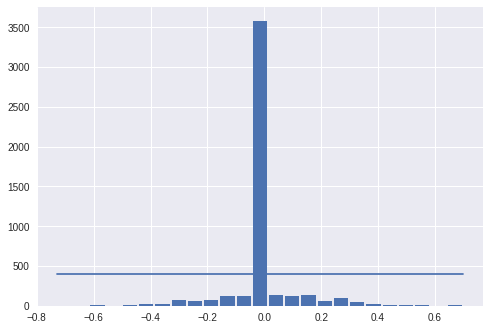

In [9]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),
        (samples_per_bin, samples_per_bin))

total data: 4725
removed 3177
remaining 1548


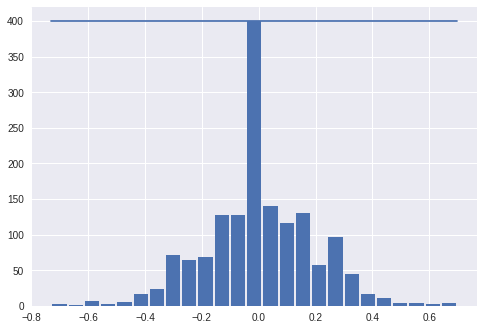

In [10]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j + 1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),
        (samples_per_bin, samples_per_bin))

In [11]:
print(data.iloc[1]) #iloc-->records based on the indexes
def load_img_steering(datadir, data):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  #Convert the input to an array.  
  image_paths = np.asarray(image_path) 
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2019_01_30_22_20_34_960.jpg
left        left_2019_01_30_22_20_34_960.jpg  
right       right_2019_01_30_22_20_34_960.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       7.82617e-05                       
Name: 13, dtype: object


In [0]:
#Split arrays or matrices into random train and test subsets
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)

In [13]:
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1238
Valid Samples: 310


Text(0.5, 1.0, 'Valid set')

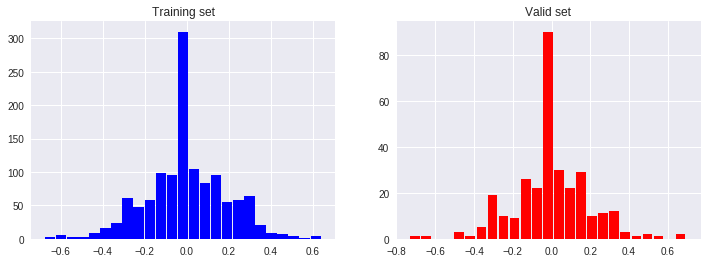

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Valid set')

In [0]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

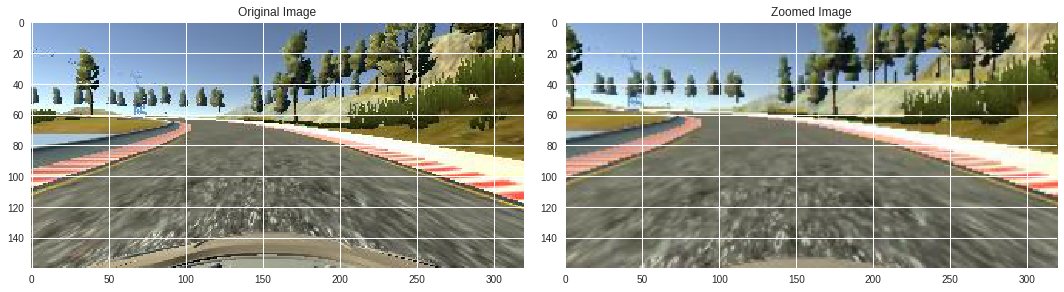

In [16]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].set_title('Original Image')

axes[1].imshow(zoomed_image)
axes[1].set_title('Zoomed Image')

In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x":(-0.1, 0.1), "y": (-0.1, 0.1) })
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

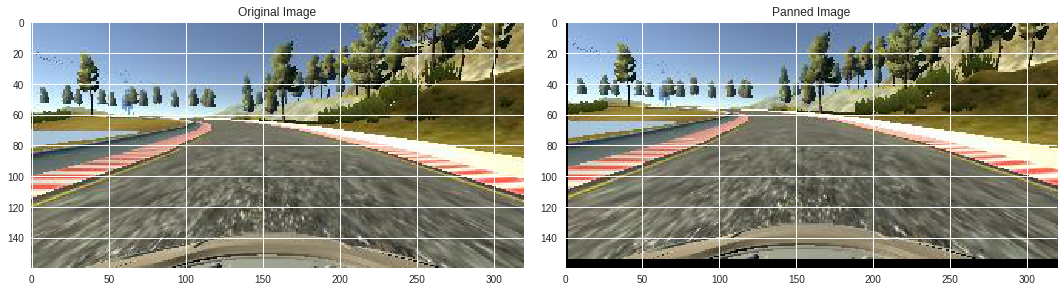

In [18]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].set_title('Original Image')

axes[1].imshow(panned_image)
axes[1].set_title('Panned Image')

In [0]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brightened Image')

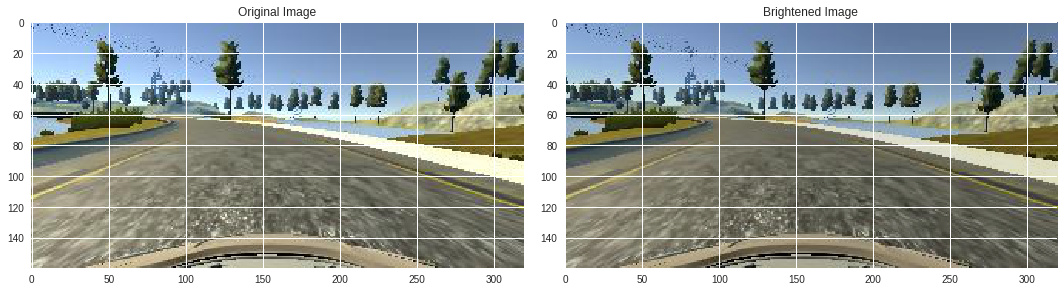

In [20]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brigtened_image = img_random_brightness(original_image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].set_title('Original Image')

axes[1].imshow(brigtened_image)
axes[1].set_title('Brightened Image')

In [0]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.15119739999999998')

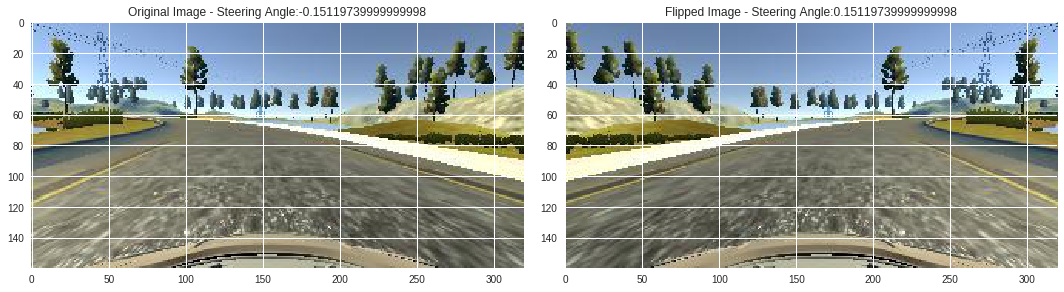

In [22]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axes[1].imshow(flipped_image)
axes[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [0]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  
  return image, steering_angle

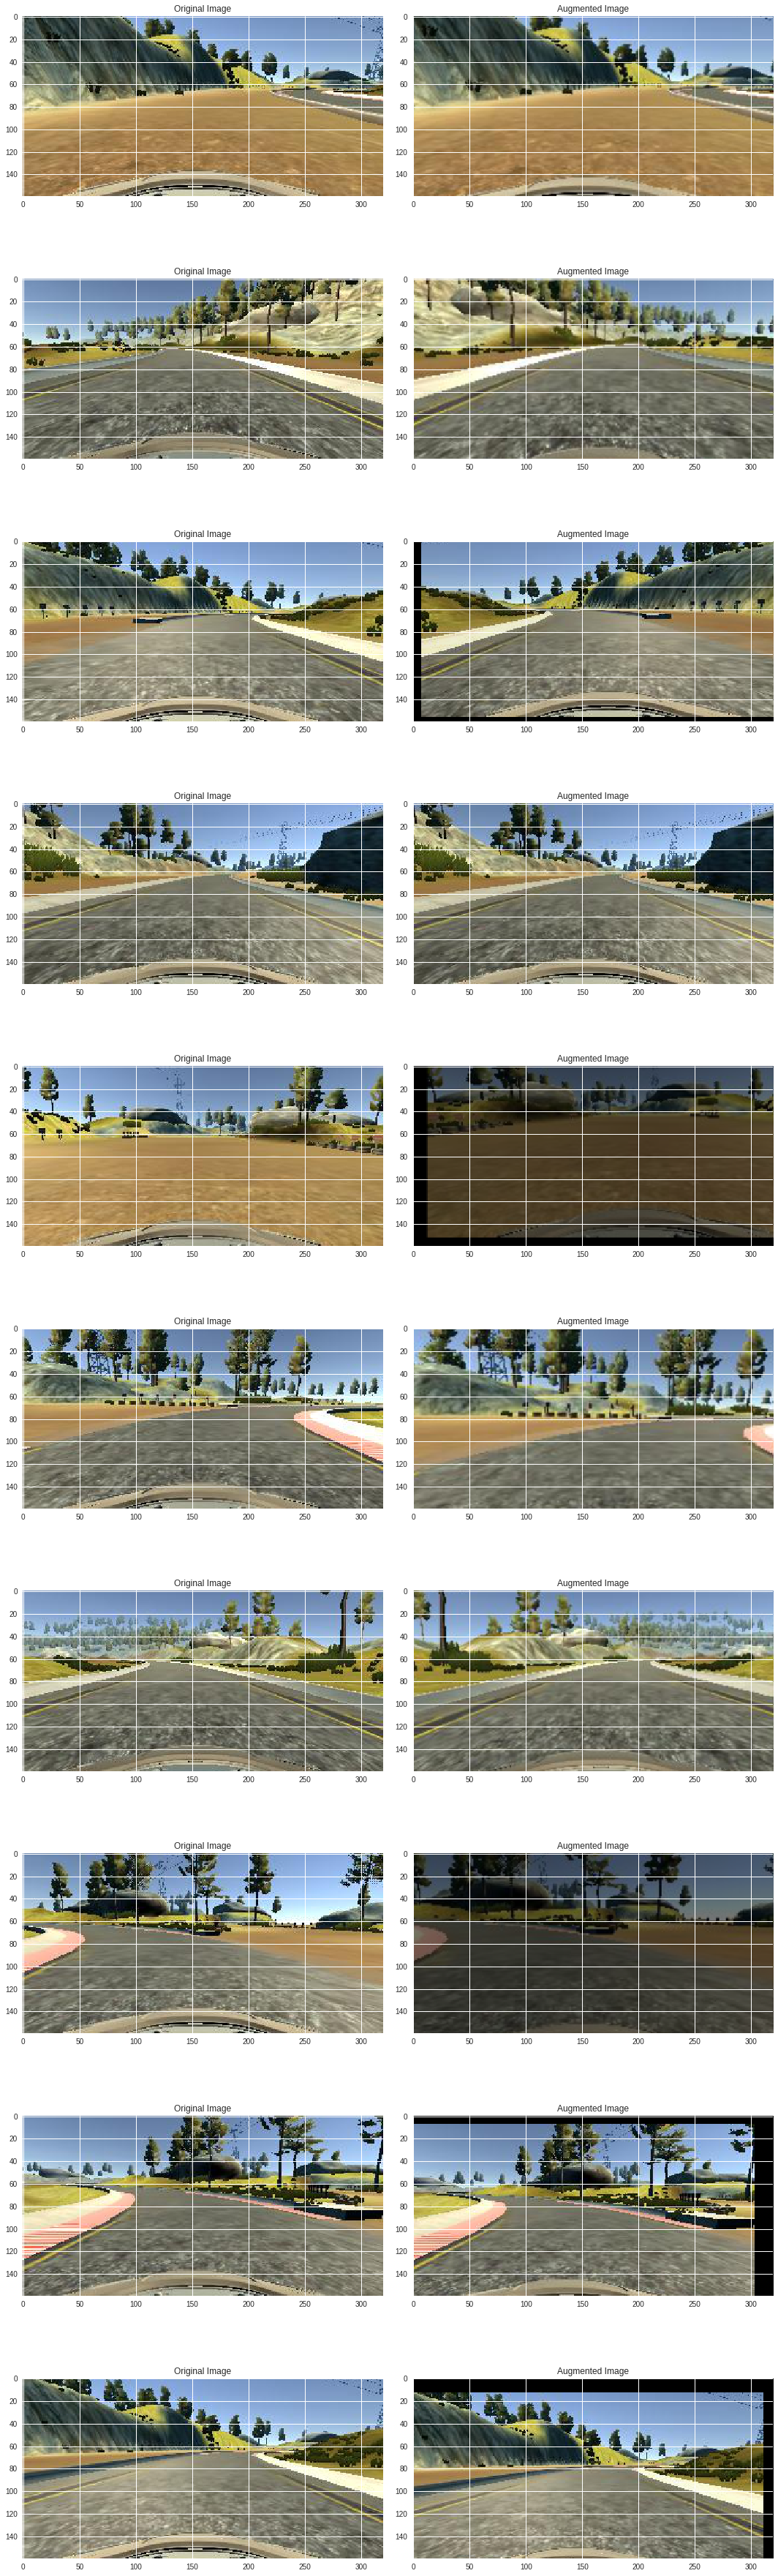

In [24]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
  
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
  
  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Image')
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augmented Image')
  
  

In [0]:
def img_preprocess(img):
  #img = mpimg.imread(img)
  img = img[60:136, :,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img / 255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

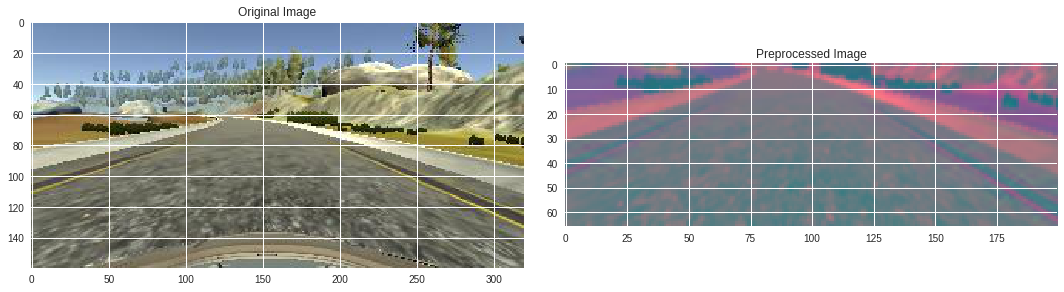

In [26]:
image = image_paths[60]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')


In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))    
        

Text(0.5, 1.0, 'Validation Image')

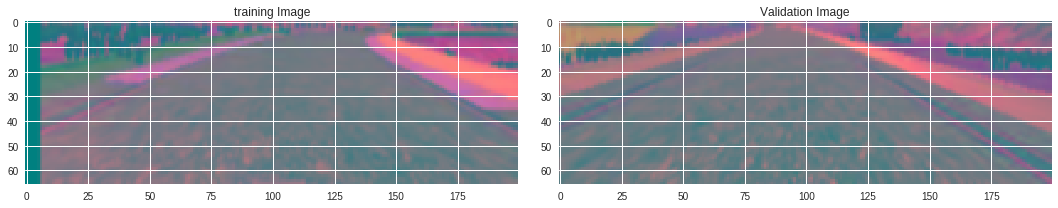

In [28]:
X_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
X_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axes[0].imshow(X_train_gen[0])
axes[0].set_title('training Image')

axes[1].imshow(X_valid_gen[0])
axes[1].set_title('Validation Image')

  92

**A "dead" ReLU** always outputs the same value (zero as it happens, but that is not important) for any input. Probably this is arrived at by learning a large negative bias term for its weights.

In turn, that means that it takes no role in discriminating between inputs. For classification, you could visualise this as a decision plane outside of all possible input data.

Once a ReLU ends up in this state, it is unlikely to recover, because the function gradient at 0 is also 0, so gradient descent learning will not alter the weights. "Leaky" ReLUs with a small positive gradient for negative inputs (y=0.01x when x < 0 say) are one attempt to address this issue and give a chance to recover.

The **sigmoid and tanh** neurons can suffer from similar problems as their values saturate, but there is always at least a small gradient allowing them to recover in the long term.

In [0]:
def nvidia_model():
  model = Sequential()
  #subsample => tuple of length 2. Factor by which to subsample output. Also called strides elsewhere.
  
  model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu')) #division decreased significantly so we will not use subsample
  model.add(Convolution2D(64, 3, 3, activation='elu')) #division decreased significantly so we will not use subsample
  #model.add(Dropout(rate=0.5)) #reduce overfitting
  
  model.add(Flatten())
  model.add(Dense(units=100, activation='elu')) #fully connected layer, 100 nodes
  #model.add(Dropout(rate=0.5)) #reduce overfitting
  
  model.add(Dense(units=50,  activation='elu')) #fully connected layer ,  50 nodes
  #model.add(Dropout(rate=0.5)) #reduce overfitting

  model.add(Dense(units=10,  activation='elu')) #fully connected layer ,  10 nodes
  #model.add(Dropout(rate=0.5)) #reduce overfitting

  model.add(Dense(1))
  
  adam = Adam(lr=1e-4) #0.0001
  model.compile(loss='mse', optimizer=adam)
  
  return model

In [30]:
model = nvidia_model()
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  if __name__ == '__main__':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               115300    
__________

In [31]:
history = model.fit_generator(batch_generator(X_train, y_train, batch_size=100,istraining=1),
                              steps_per_epoch=300, 
                              epochs=10,
                              validation_data=batch_generator(X_valid, y_valid, 100, 0),
                              validation_steps=200,
                              verbose=1, 
                              shuffle=1)
         

Epoch 1/10
300/300 [==============================] - 155s 515ms/step - loss: 0.0354 - val_loss: 0.0248
Epoch 2/10
300/300 [==============================] - 147s 489ms/step - loss: 0.0280 - val_loss: 0.0223
Epoch 3/10
300/300 [==============================] - 147s 491ms/step - loss: 0.0257 - val_loss: 0.0253
Epoch 4/10
300/300 [==============================] - 144s 482ms/step - loss: 0.0239 - val_loss: 0.0186
Epoch 5/10
300/300 [==============================] - 144s 480ms/step - loss: 0.0224 - val_loss: 0.0186
Epoch 6/10
300/300 [==============================] - 145s 483ms/step - loss: 0.0221 - val_loss: 0.0179
Epoch 7/10
300/300 [==============================] - 144s 480ms/step - loss: 0.0204 - val_loss: 0.0182
Epoch 8/10
300/300 [==============================] - 142s 474ms/step - loss: 0.0199 - val_loss: 0.0189
Epoch 9/10
300/300 [==============================] - 142s 473ms/step - loss: 0.0197 - val_loss: 0.0185
Epoch 10/10
300/300 [==============================] - 139s 464m

Text(0.5, 0, 'Epoch')

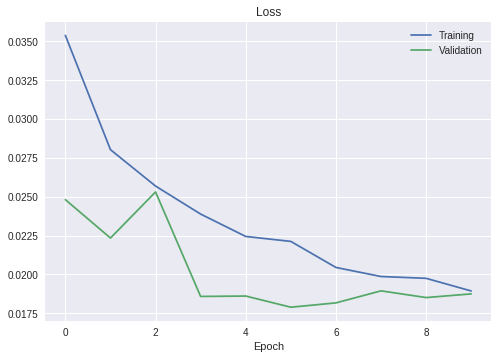

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')